In [1]:
import scipy.stats as sps
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from graphviz import Digraph

from statsmodels.stats.proportion import proportion_confint
from statsmodels.formula.api import ols

from catboost import CatBoostRegressor
from joblib import Parallel, delayed

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", font_scale=1, palette="Set2")

# Анализ пользовательской активности на образовательном портале Teach-in.ru

## Описание проекта
Анализ данных о визитах пользователей на сайте Teach-in.ru — образовательной платформе, посвященной дополнительному образованию и курсам повышения квалификации. Данные охватывают период с 2020 года.

**Определение визита:** Визит — это последовательность действий пользователя на сайте, которая начинается на некоторой странице сайта, содержит в себе переходы по ссылкам (просмотр курсов, изучение программ, регистрация) и другие действия, и заканчивается на какой-то, возможно, другой страницей сайта. Визит считается завершенным, если активность отсутствует в течение 30 минут.

## Задачи анализа
1. Сколько всего визитов представлено в данных?
2. Когда совершены первый и последний визиты?
3. Постройте динамику количества визитов во времени по дням
4. Сколько уникальных пользователей в данных?
5. Сколько в среднем один пользователь совершил визитов? Сколько максимально?
6. Постройте гистограмму глубины и продолжительности визитов
7. Из каких стран больше пользователей?
8. Какие браузеры и операционные системы в топе?

___

Считаем данные

In [2]:
data = pd.read_csv("data.tsv", sep="\t")
data.head()

,visitID,clientID,dateTimeUTC,startURL,endURL,pageViews,visitDuration,isNewUser,bounce,regionCountry,...,browserCountry,mobilePhone,operatingSystemRoot,browser,browserEngine,screenOrientation,screenWidth,screenHeight,windowClientWidth,windowClientHeight
0,1.801686e+19,1568056026568729022,2020-12-31 03:28:50,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,1,0,1,Russia,...,gb,NaN,gnu_linux,chrome,WebKit,2,1920,1080,1905,981
1,1.802359e+19,1577864187752491163,2020-12-31 10:36:27,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,9,215,1,0,Singapore,...,us,apple,ios_double,safari_mobile,WebKit,1,375,667,375,559
2,1.802460e+19,1567765219104836417,2020-12-31 11:40:44,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,88,0,0,Russia,...,ru,apple,ios_double,yandex_browser,WebKit,1,414,736,414,660
3,1.802475e+19,1576839432510419026,2020-12-31 11:50:13,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,19,0,0,China,...,ru,samsung,android,chromemobile,WebKit,1,412,892,412,756
4,1.802518e+19,1576246599115183097,2020-12-31 12:17:33,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,2,0,0,Russia,...,ru,NaN,gnu_linux,firefox,Gecko,2,1920,1080,913,942


Изменим тип на дату.

In [3]:
data["dateTimeUTC"] = pd.to_datetime(data["dateTimeUTC"])

## 1. Исследование данных

Решим пункты 1, 2, 4, 5.

In [4]:
visits_per_user = data.groupby('clientID').size()
print(f"""
Количество визитов: {len(data):,}
Первый визит: {data["dateTimeUTC"].min().strftime("%Y-%m-%d")}
Последний визит: {data["dateTimeUTC"].max().strftime("%Y-%m-%d")}
Уникальных пользователей: {data["clientID"].nunique():,}
В среднем визитов на пользователя: {visits_per_user.mean():.1f}
Максимум визитов: {visits_per_user.max()}
""")


Количество визитов: 387,353
Первый визит: 2020-12-31
Последний визит: 2025-02-24
Уникальных пользователей: 162,474
В среднем визитов на пользователя: 2.4
Максимум визитов: 58700



Разобьем время посещение на дату и на час, а также выделим год и месяц

In [5]:
data["hour"] = data["dateTimeUTC"].dt.hour
data["date"] = pd.to_datetime(data["dateTimeUTC"].dt.date)
data["year"] = data["date"].apply(lambda dt: dt.year)
data["month"] = data["date"].apply(lambda dt: dt.month)
data = data[data['dateTimeUTC'] >= '2021-01-01']
data

,visitID,clientID,dateTimeUTC,startURL,endURL,pageViews,visitDuration,isNewUser,bounce,regionCountry,...,browserEngine,screenOrientation,screenWidth,screenHeight,windowClientWidth,windowClientHeight,hour,date,year,month
16,1.803658e+19,1577913752716130576,2021-01-01 00:22:34,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,15,1,0,NaN,...,WebKit,2,1366,768,1349,608,0,2021-01-01,2021,1
17,1.803668e+19,1568056026568729022,2021-01-01 00:28:51,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,17,0,0,Russia,...,WebKit,2,1920,1080,1905,981,0,2021-01-01,2021,1
18,1.803746e+19,1567465093162705334,2021-01-01 01:18:24,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,0,0,1,Russia,...,WebKit,1,375,667,375,551,1,2021-01-01,2021,1
19,1.803809e+19,1566646596524658728,2021-01-01 01:58:15,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,16,0,0,Russia,...,WebKit,2,1920,1080,1905,938,1,2021-01-01,2021,1
20,1.804237e+19,1577935847578546290,2021-01-01 06:30:47,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/index.html,2,2,1,0,United States,...,WebKit,2,1366,768,1351,768,6,2021-01-01,2021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387348,8.349148e+17,170889374781031580,2025-02-24 23:42:27,https://miptstats.github.io/,https://miptstats.github.io/,1,15,1,0,Russia,...,WebKit,1,384,832,384,756,23,2025-02-24,2025,2
387349,8.349555e+17,1706366044539443064,2025-02-24 23:45:02,https://miptstats.github.io/courses/python/09_...,https://miptstats.github.io/courses/python/09_...,1,0,0,1,Russia,...,WebKit,2,1600,900,1583,771,23,2025-02-24,2025,2
387350,8.350287e+17,1707574597556843446,2025-02-24 23:49:41,https://miptstats.github.io/courses/ad_fivt/ta...,https://miptstats.github.io/courses/ad_fivt/ta...,1,0,0,1,Russia,...,WebKit,2,1536,864,1519,729,23,2025-02-24,2025,2
387351,8.350809e+17,17088943799001288,2025-02-24 23:52:59,https://mipt-stats.gitlab.io/courses/python/05...,https://mipt-stats.gitlab.io/courses/python/05...,1,23,1,0,Russia,...,WebKit,1,393,851,393,687,23,2025-02-24,2025,2


#### Количество визитов по часам

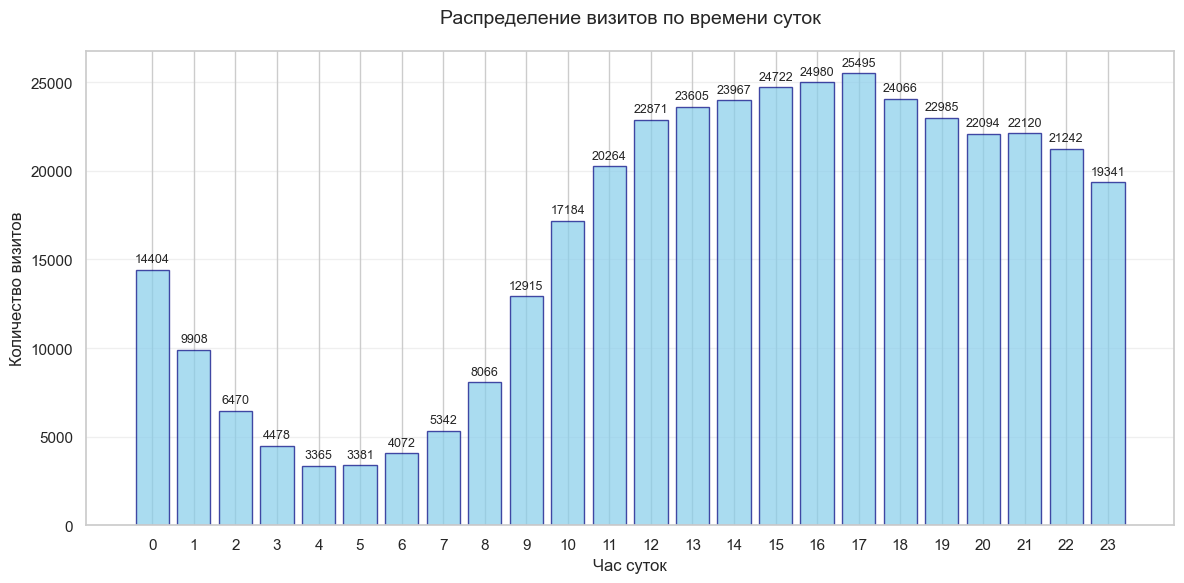

In [6]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(12, 6))
    
    
    hours_count = data["hour"].astype(int).value_counts().sort_index()
    
    bars = plt.bar(hours_count.index, hours_count.values, 
                   color='skyblue', edgecolor='navy', alpha=0.7)
    
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(hours_count.values)*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    plt.xlabel("Час суток", fontsize=12)
    plt.ylabel("Количество визитов", fontsize=12)
    plt.title("Распределение визитов по времени суток", fontsize=14, pad=20)
    plt.xticks(range(24))
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

#### Динамика количества визитов во времени по дням

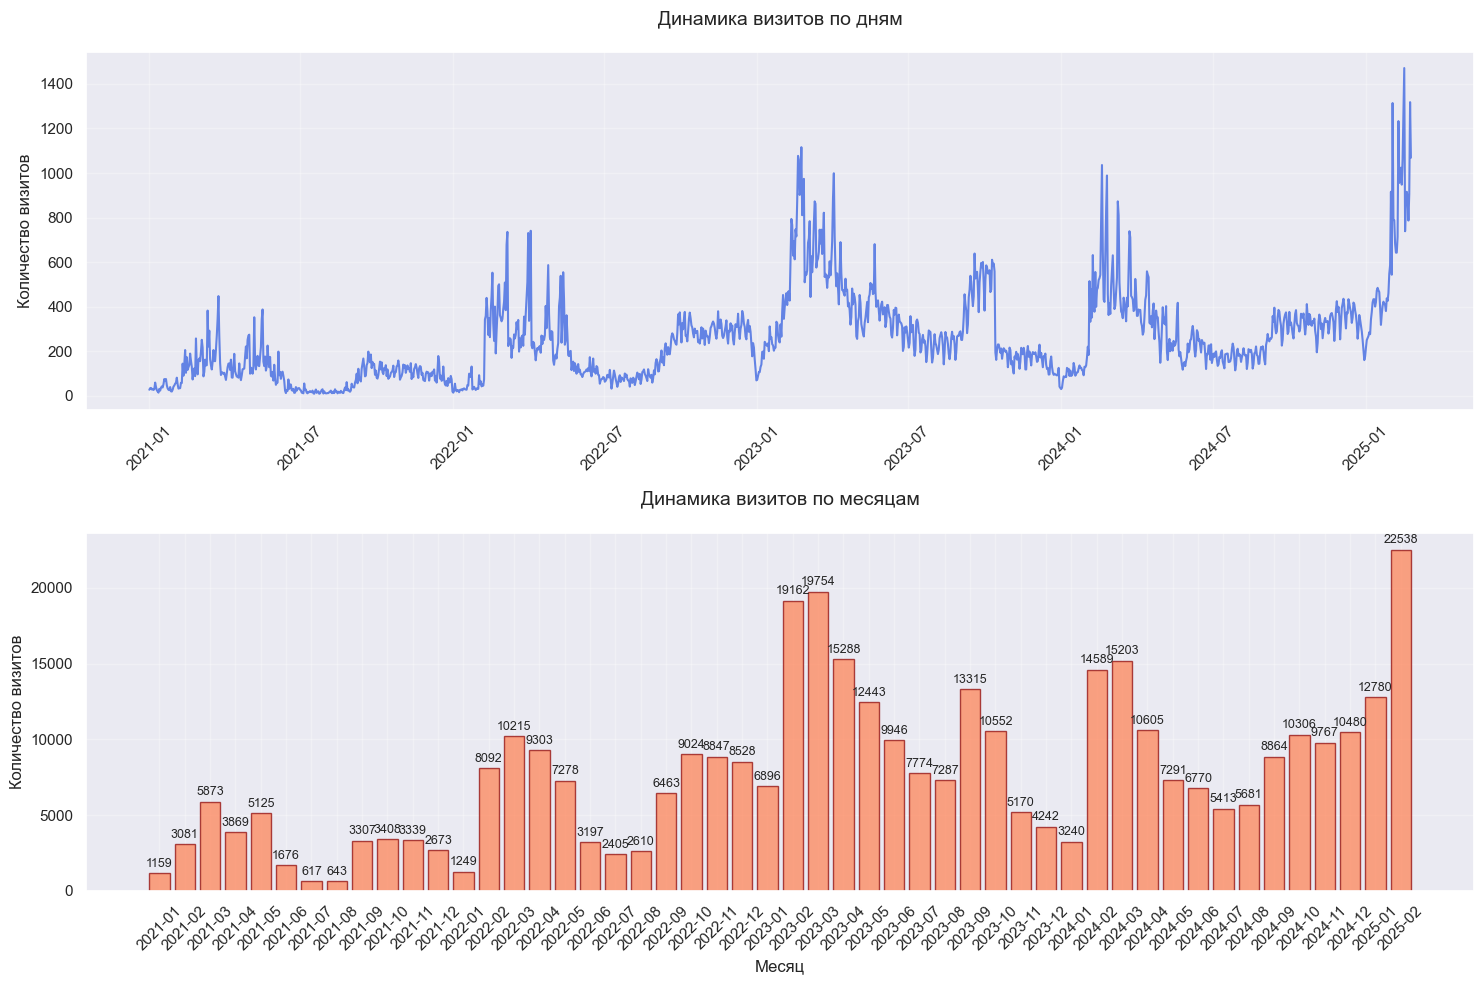

In [7]:
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    
    daily_visits = data.groupby("date")["clientID"].count()
    ax1.plot(daily_visits.index, daily_visits.values, 
             linewidth=1.5, color='royalblue', alpha=0.8)
    ax1.set_ylabel("Количество визитов", fontsize=12)
    ax1.set_title("Динамика визитов по дням", fontsize=14, pad=20)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    
    data['month'] = data['date'].dt.to_period('M').astype(str)
    monthly_visits = data.groupby("month")["clientID"].count()
    
    ax2.bar(monthly_visits.index, monthly_visits.values, 
            color='coral', alpha=0.7, edgecolor='darkred')
    ax2.set_ylabel("Количество визитов", fontsize=12)
    ax2.set_xlabel("Месяц", fontsize=12)
    ax2.set_title("Динамика визитов по месяцам", fontsize=14, pad=20)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    
    for i, value in enumerate(monthly_visits.values):
        ax2.text(i, value + max(monthly_visits.values)*0.01, 
                f'{int(value)}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

Можем наблюдать наличие пиков-выбросов во временных периодах

####  Глубина и длительность просмотров

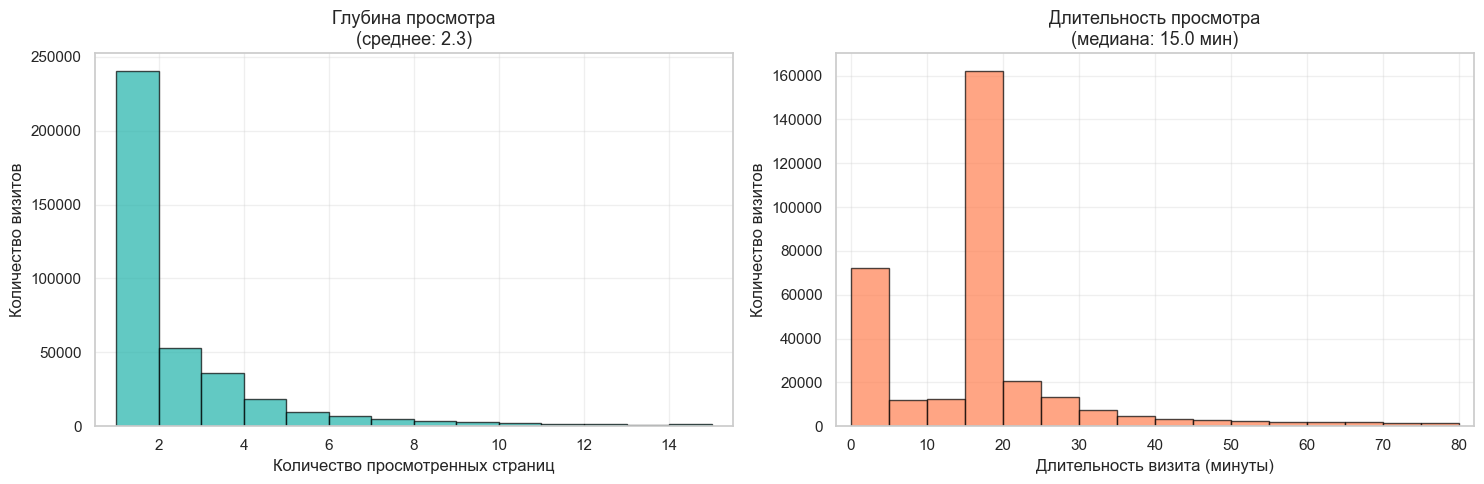

In [8]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    
    axes[0].hist(data["pageViews"], bins=np.arange(1, 16), 
                 color='lightseagreen', alpha=0.7, edgecolor='black')
    axes[0].set_xlabel("Количество просмотренных страниц", fontsize=12)
    axes[0].set_ylabel("Количество визитов", fontsize=12)
    axes[0].set_title(f"Глубина просмотра\n(среднее: {data['pageViews'].mean():.1f})", fontsize=13)
    axes[0].set_xlim(0.5, 15.5)
    axes[0].grid(True, alpha=0.3)
    
    
    axes[1].hist(data["visitDuration"], bins=np.arange(0, 85, 5), 
                 color='coral', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel("Длительность визита (минуты)", fontsize=12)
    axes[1].set_ylabel("Количество визитов", fontsize=12)
    axes[1].set_title(f"Длительность просмотра\n(медиана: {data['visitDuration'].median():.1f} мин)", fontsize=13)
    axes[1].set_xlim(-2, 82)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Есть явно выбросные значения. Странно, что длительность просмотра часто находится в пределах 15-20, но в бинах рядом значения принимаются сильно реже.

#### Топ браузеров

Cразу же будем заменять редко встречающиеся значения на `other`.

Топ-10 самых популярных браузеров (без объединения)


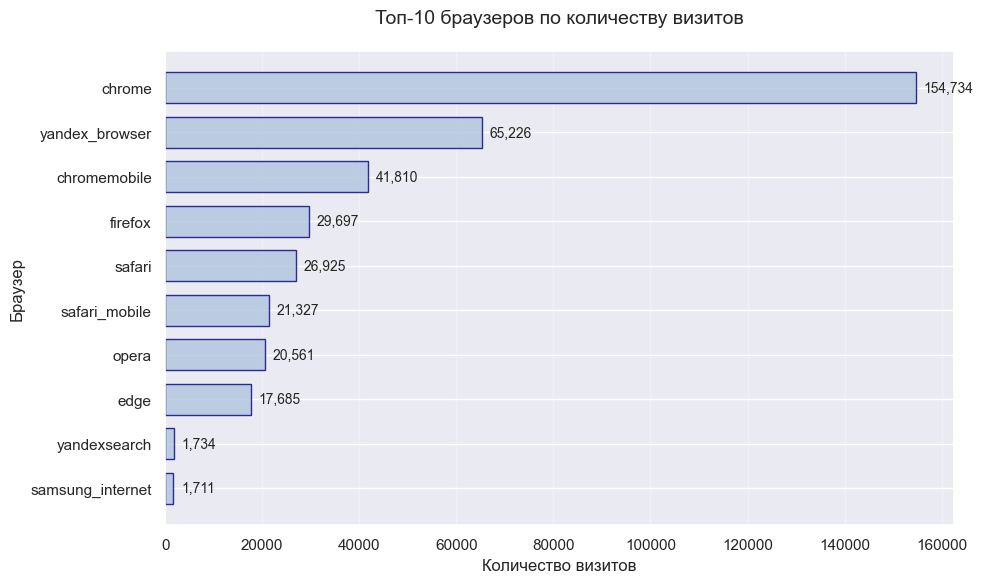

In [9]:

print("Топ-10 самых популярных браузеров (без объединения)")

data["browser"] = data["browser"].astype(str)
browser_counts = (
    data.groupby(by="browser")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
top_10_browsers = browser_counts.head(10)


bars = plt.barh(range(len(top_10_browsers)), top_10_browsers.values, 
                color='lightsteelblue', edgecolor='navy', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Браузер", fontsize=12)
plt.title("Топ-10 браузеров по количеству визитов", fontsize=14, pad=20)
plt.yticks(range(len(top_10_browsers)), top_10_browsers.index)
plt.grid(axis='x', alpha=0.3)


for i, (browser, count) in enumerate(top_10_browsers.items()):
    plt.text(count + max(top_10_browsers.values)*0.01, i,
             f'{int(count):,}', ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

Топ браузеров с объединением редких в 'other'


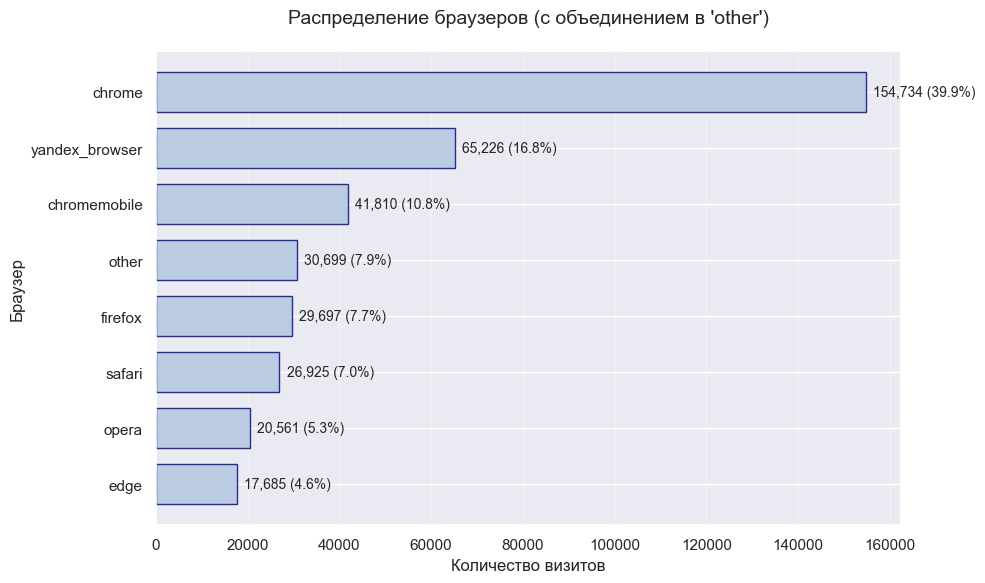

In [10]:

print("Топ браузеров с объединением редких в 'other'")

browsers = [
    "chrome",
    "yandex_browser", 
    "chromemobile",
    "firefox",
    "safari",
    "opera",
    "edge",
]

data.loc[~data["browser"].isin(browsers), "browser"] = "other"

browser_counts_merged = (
    data.groupby(by="browser")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(browser_counts_merged)), browser_counts_merged.values,
                color='lightsteelblue', edgecolor='navy', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Браузер", fontsize=12)
plt.title("Распределение браузеров (с объединением в 'other')", fontsize=14, pad=20)
plt.yticks(range(len(browser_counts_merged)), browser_counts_merged.index)
plt.grid(axis='x', alpha=0.3)

total_visits = len(data)
for i, (browser, count) in enumerate(browser_counts_merged.items()):
    percentage = (count / total_visits) * 100
    plt.text(count + max(browser_counts_merged.values)*0.01, i,
             f'{int(count):,} ({percentage:.1f}%)', 
             ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Топ по странам

Топ-10 стран по количеству визитов


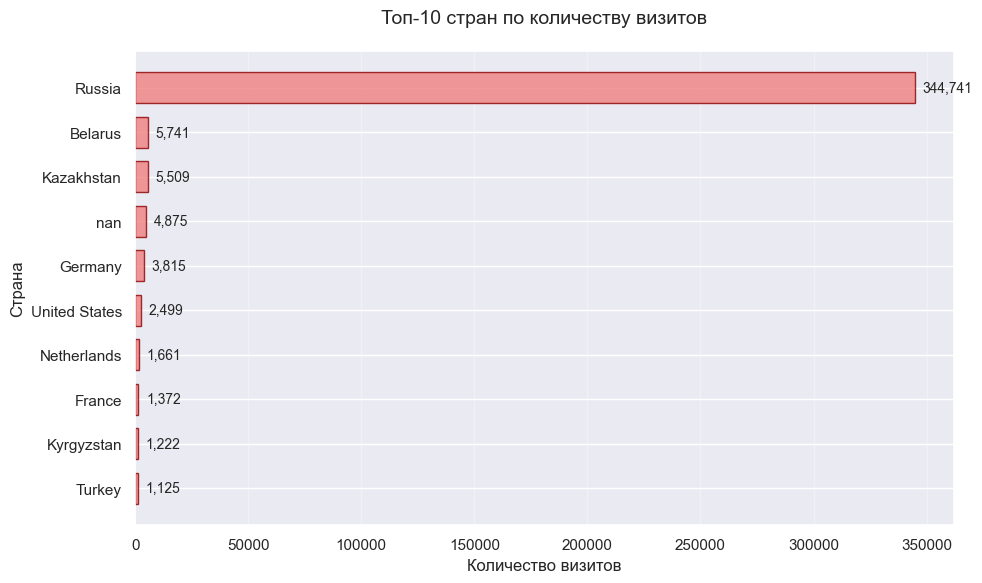

In [11]:

print("Топ-10 стран по количеству визитов")

data["regionCountry"] = data["regionCountry"].astype(str)
country_counts = (
    data.groupby(by="regionCountry")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
top_10_countries = country_counts.head(10)

bars = plt.barh(range(len(top_10_countries)), top_10_countries.values, 
                color='lightcoral', edgecolor='darkred', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Страна", fontsize=12)
plt.title("Топ-10 стран по количеству визитов", fontsize=14, pad=20)
plt.yticks(range(len(top_10_countries)), top_10_countries.index)
plt.grid(axis='x', alpha=0.3)

for i, (country, count) in enumerate(top_10_countries.items()):
    plt.text(count + max(top_10_countries.values)*0.01, i,
             f'{int(count):,}', ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Распределение визитов: Россия vs другие страны


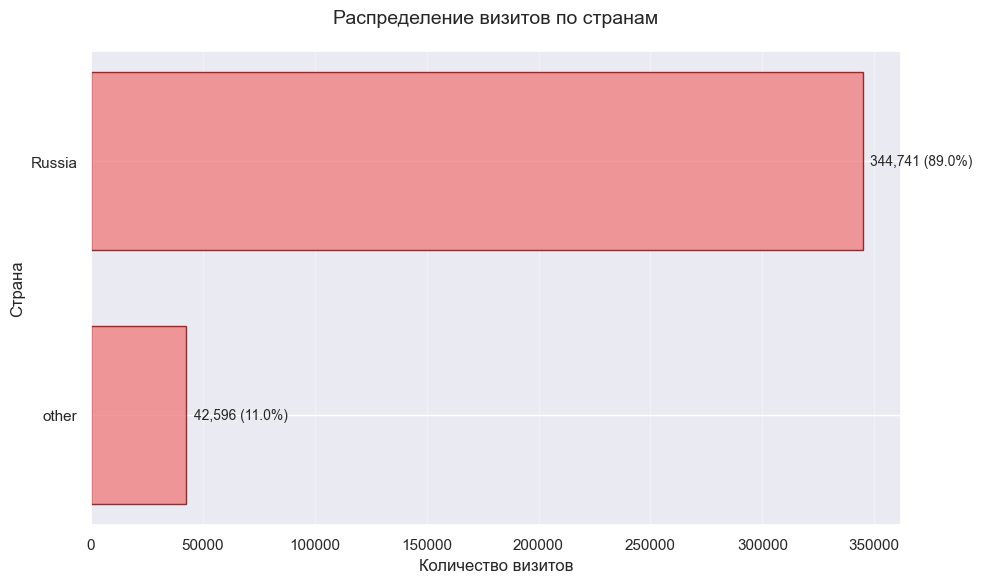

In [12]:
print("Распределение визитов: Россия vs другие страны")

data.loc[data["regionCountry"] != "Russia", "regionCountry"] = "other"

country_counts_merged = (
    data.groupby(by="regionCountry")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(country_counts_merged)), country_counts_merged.values,
                color='lightcoral', edgecolor='darkred', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Страна", fontsize=12)
plt.title("Распределение визитов по странам", fontsize=14, pad=20)
plt.yticks(range(len(country_counts_merged)), country_counts_merged.index)
plt.grid(axis='x', alpha=0.3)

total_visits = len(data)
for i, (country, count) in enumerate(country_counts_merged.items()):
    percentage = (count / total_visits) * 100
    plt.text(count + max(country_counts_merged.values)*0.01, i,
             f'{int(count):,} ({percentage:.1f}%)', 
             ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Топ по ОС

Самые популярные ОС


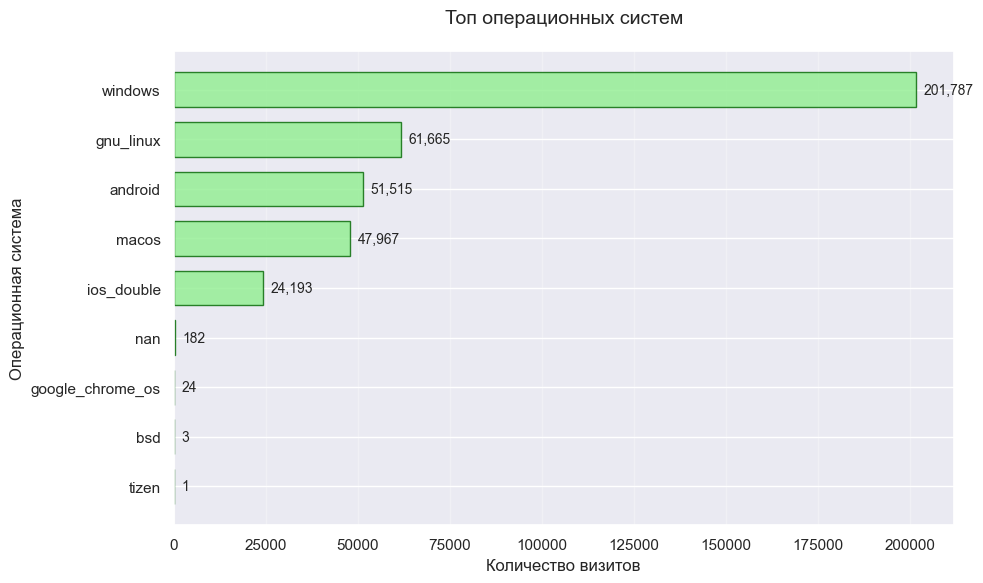

In [13]:
print("Самые популярные ОС")
data["operatingSystemRoot"] = data["operatingSystemRoot"].astype(str)
os_counts = (
    data.groupby(by="operatingSystemRoot")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
top_os = os_counts.head(10)

bars = plt.barh(range(len(top_os)), top_os.values, 
                color='lightgreen', edgecolor='darkgreen', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Операционная система", fontsize=12)
plt.title("Топ операционных систем", fontsize=14, pad=20)
plt.yticks(range(len(top_os)), top_os.index)
plt.grid(axis='x', alpha=0.3)

for i, (os_name, count) in enumerate(top_os.items()):
    plt.text(count + max(top_os.values)*0.01, i,
             f'{int(count):,}', ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Самые популярные ОС без лишнего шума


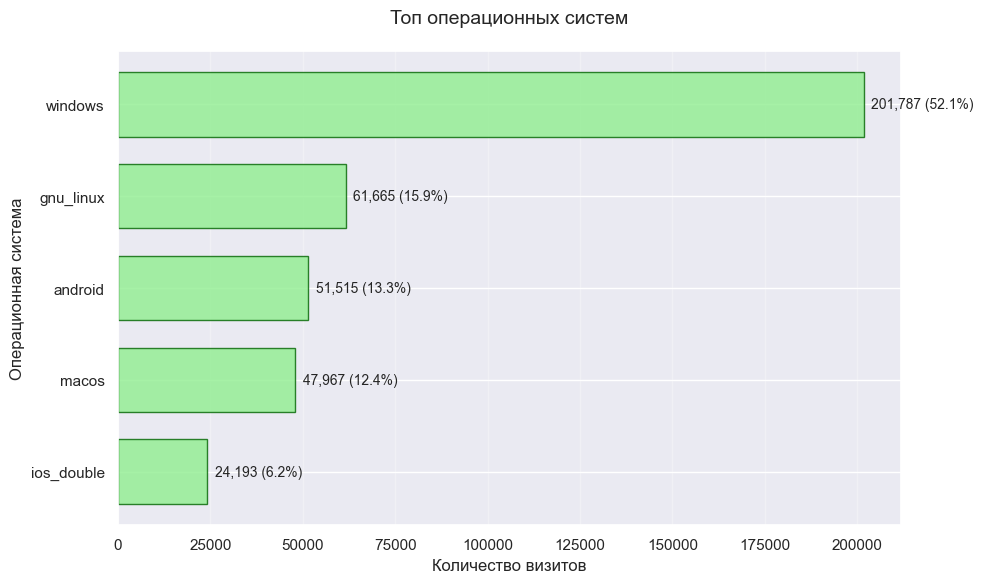

In [14]:
print("Самые популярные ОС без лишнего шума")
os_list = ["windows", "gnu_linux", "android", "macos", "ios_double"]
data = data[data["operatingSystemRoot"].isin(os_list)]

os_counts_merged = (
    data.groupby(by="operatingSystemRoot")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(os_counts_merged)), os_counts_merged.values,
                color='lightgreen', edgecolor='darkgreen', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Операционная система", fontsize=12)
plt.title("Топ операционных систем", fontsize=14, pad=20)
plt.yticks(range(len(os_counts_merged)), os_counts_merged.index)
plt.grid(axis='x', alpha=0.3)

total_visits = len(data)
for i, (os_name, count) in enumerate(os_counts_merged.items()):
    percentage = (count / total_visits) * 100
    plt.text(count + max(os_counts_merged.values)*0.01, i,
             f'{int(count):,} ({percentage:.1f}%)', 
             ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Ориентации экрана

Самые популярные ориентации экрана


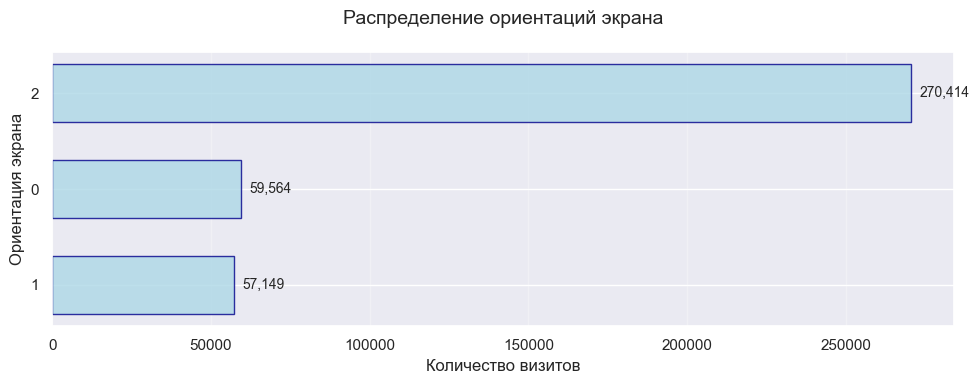

In [15]:
print("Самые популярные ориентации экрана")
orientation_counts = (
    data.groupby(by="screenOrientation")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 4))
bars = plt.barh(range(len(orientation_counts)), orientation_counts.values,
                color='lightblue', edgecolor='darkblue', alpha=0.8, height=0.6)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Ориентация экрана", fontsize=12)
plt.title("Распределение ориентаций экрана", fontsize=14, pad=20)
plt.yticks(range(len(orientation_counts)), orientation_counts.index)
plt.grid(axis='x', alpha=0.3)

for i, (orientation, count) in enumerate(orientation_counts.items()):
    plt.text(count + max(orientation_counts.values)*0.01, i,
             f'{int(count):,}', ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Типы интернет-сетей

Самые популярные типы сетей


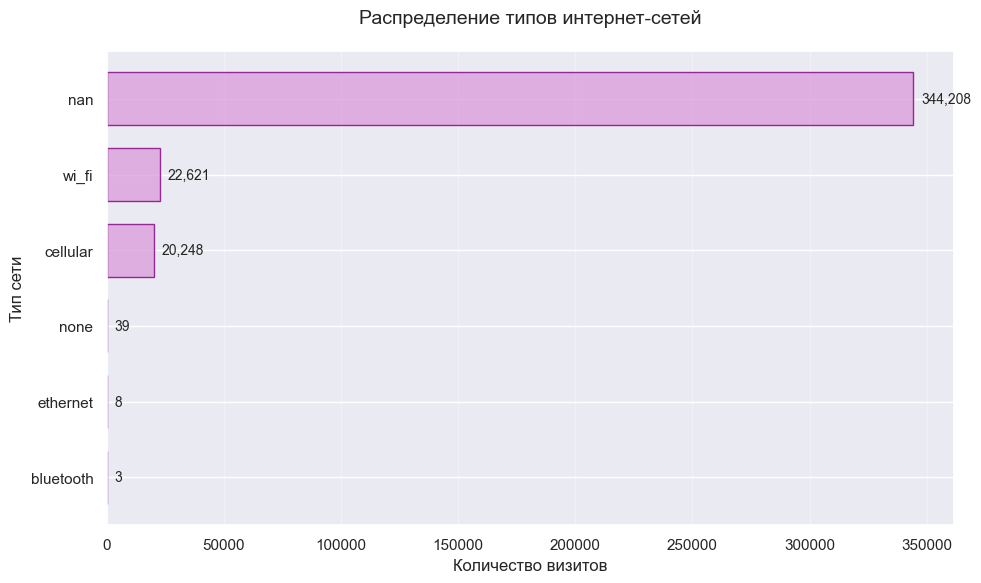

In [16]:
print("Самые популярные типы сетей")
data["networkType"] = data["networkType"].astype(str)
network_counts = (
    data.groupby(by="networkType")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(network_counts)), network_counts.values,
                color='plum', edgecolor='purple', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Тип сети", fontsize=12)
plt.title("Распределение типов интернет-сетей", fontsize=14, pad=20)
plt.yticks(range(len(network_counts)), network_counts.index)
plt.grid(axis='x', alpha=0.3)

for i, (network, count) in enumerate(network_counts.items()):
    plt.text(count + max(network_counts.values)*0.01, i,
             f'{int(count):,}', ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Самые популярные типы сетей (фильтрация)


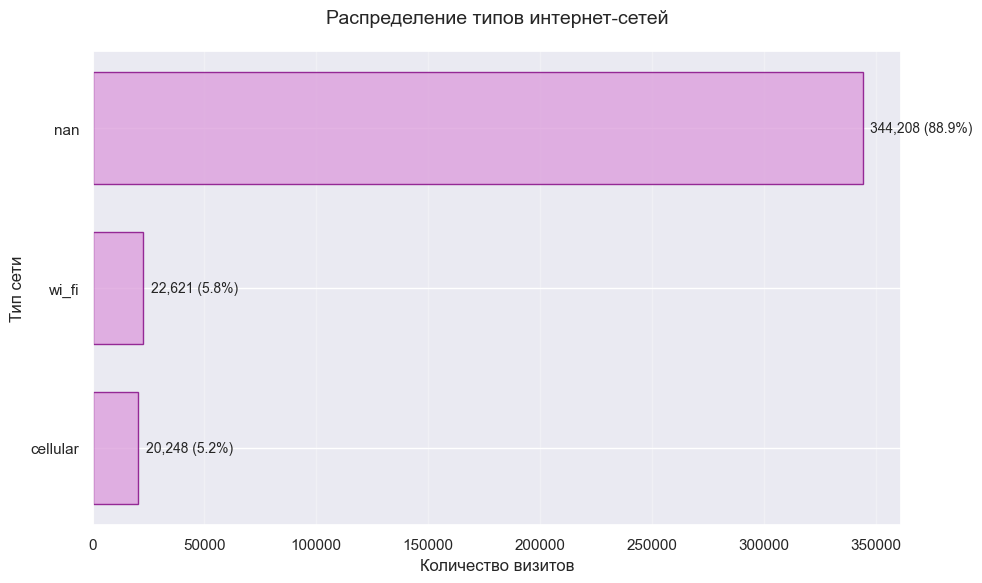

In [17]:
print("Самые популярные типы сетей (фильтрация)")
network_types = ["nan", "wi_fi", "cellular"]
data = data[data["networkType"].isin(network_types)]

network_counts = (
    data.groupby(by="networkType")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(network_counts)), network_counts.values,
                color='plum', edgecolor='purple', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Тип сети", fontsize=12)
plt.title("Распределение типов интернет-сетей", fontsize=14, pad=20)
plt.yticks(range(len(network_counts)), network_counts.index)
plt.grid(axis='x', alpha=0.3)

total_visits = len(data)
for i, (network, count) in enumerate(network_counts.items()):
    percentage = (count / total_visits) * 100
    plt.text(count + max(network_counts.values)*0.01, i,
             f'{int(count):,} ({percentage:.1f}%)', 
             ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Тип точки входа на сайт

Типы сайтов


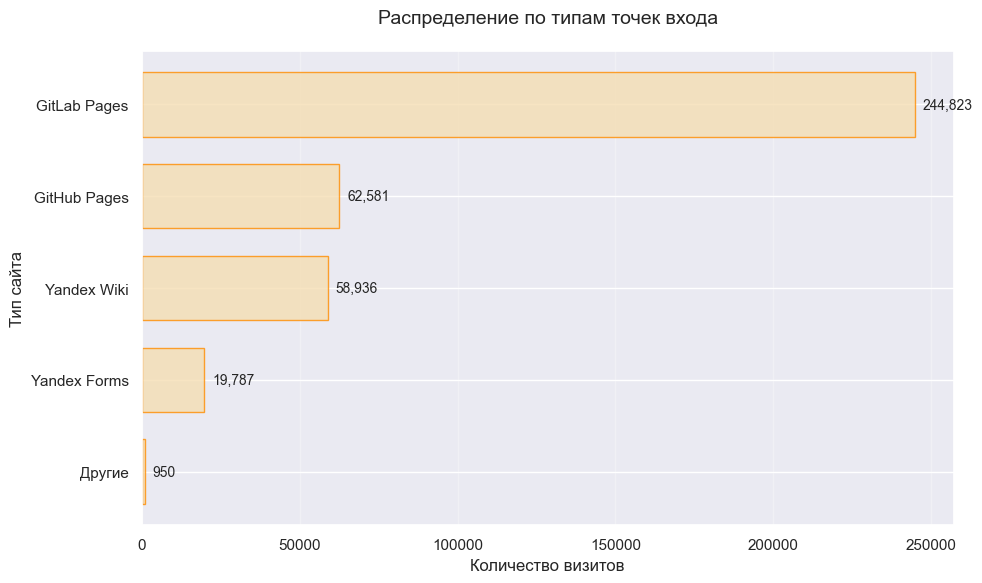

In [18]:
site_types = []
data["startURL"] = data["startURL"].astype(str)

for i in range(len(data)):
    if "github.io" in data["startURL"].iloc[i]:
        site_types.append(0)
    elif "gitlab.io" in data["startURL"].iloc[i]:
        site_types.append(1)
    elif "wiki.yandex.ru" in data["startURL"].iloc[i]:
        site_types.append(2)
    elif "forms.yandex.ru" in data["startURL"].iloc[i]:
        site_types.append(3)
    else:
        site_types.append(4)

data["siteType"] = site_types

print("Типы сайтов")
site_type_counts = (
    data.groupby(by="siteType")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

site_type_labels = {
    0: "GitHub Pages",
    1: "GitLab Pages", 
    2: "Yandex Wiki",
    3: "Yandex Forms",
    4: "Другие"
}

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(site_type_counts)), site_type_counts.values,
                color='wheat', edgecolor='darkorange', alpha=0.8, height=0.7)

plt.xlabel("Количество визитов", fontsize=12)
plt.ylabel("Тип сайта", fontsize=12)
plt.title("Распределение по типам точек входа", fontsize=14, pad=20)
plt.yticks(range(len(site_type_counts)), [site_type_labels[i] for i in site_type_counts.index])
plt.grid(axis='x', alpha=0.3)

for i, (site_type, count) in enumerate(site_type_counts.items()):
    plt.text(count + max(site_type_counts.values)*0.01, i,
             f'{int(count):,}', ha='left', va='center', fontsize=10)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [19]:
data = data[data["siteType"].isin([0, 1])]

## 2. Дизайн теста

В апреле команда образовательного портала Teach-in.ru планирует провести A/B тест продолжительностью 4 недели, в рамках которого будет изменен дизайн главной страницы: добавлены интерактивные элементы навигации, улучшена визуальная структура разделов и оптимизирован процесс выбора образовательных программ. 

*Гипотеза — средняя по посетителям глубина просмотра страниц вырастет на 5%.*

Вам, как аналитику, предстоит задизайнить этот эксперимент.

Выберите размеры групп на основе некоторых соображений.

----

In [21]:
data["hour"] = data["dateTimeUTC"].dt.hour
data["date"] = pd.to_datetime(data["dateTimeUTC"].dt.date)
data["year"] = data["date"].apply(lambda dt: dt.year)
data["month"] = data["date"].apply(lambda dt: dt.month)

Посмотрим на кол-во уникальных пользователей в каждом из месяцев.

In [26]:
monthly_stats = (
    data.groupby(["year", "month"])
    .aggregate({"clientID": pd.Series.nunique})
    .reset_index()
)

monthly_stats["month_date"] = monthly_stats.apply(
    lambda x: pd.to_datetime(f"{x['year']}-{x['month']}-01"), 
    axis=1
)

monthly_stats = monthly_stats.set_index("month_date")
monthly_stats

,year,month,clientID
month_date,,,
2021-01-01,2021,1,349
2021-02-01,2021,2,850
2021-03-01,2021,3,1060
2021-04-01,2021,4,744
2021-05-01,2021,5,823
2021-06-01,2021,6,432
2021-07-01,2021,7,240
2021-08-01,2021,8,293
2021-09-01,2021,9,581


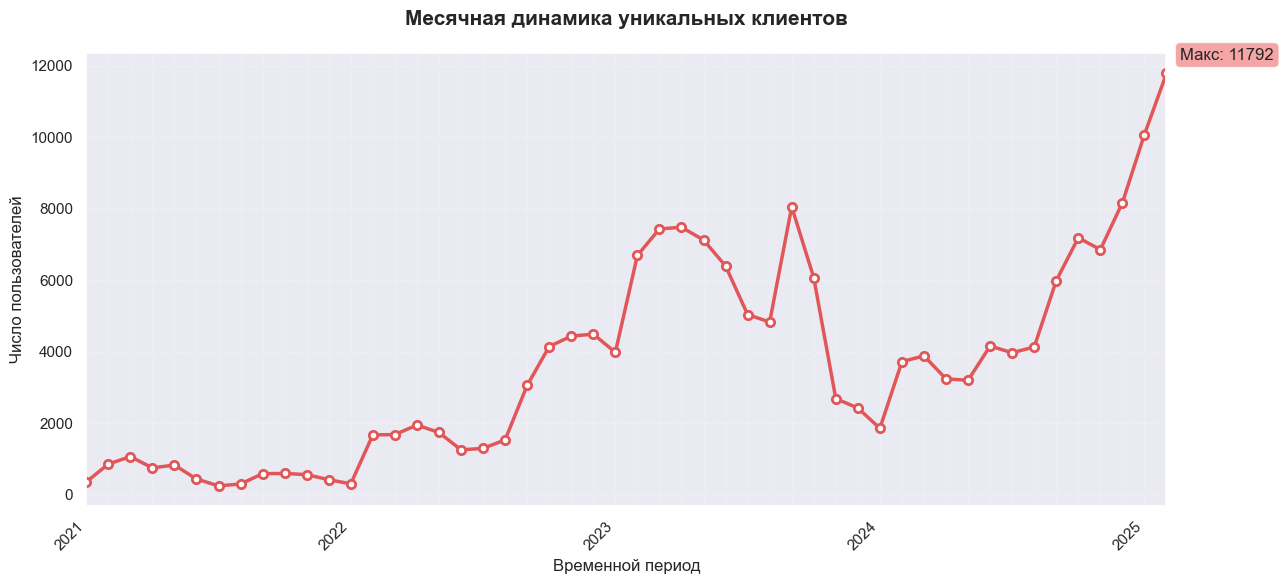

In [30]:
plt.figure(figsize=(13, 6))
ax = plt.subplot()

monthly_stats["clientID"].plot(linewidth=2.5, color='#E15759', marker='o', 
                              markersize=6, markerfacecolor='white', markeredgewidth=2)

plt.ylabel("Число пользователей", fontsize=12, fontweight='medium')
plt.xlabel("Временной период", fontsize=12, fontweight='medium')
plt.title("Месячная динамика уникальных клиентов", fontsize=15, pad=20, fontweight='bold')

plt.grid(True, alpha=0.25, linestyle='--')

# Добавляем метки для крайних точек
max_val = monthly_stats["clientID"].max()
min_val = monthly_stats["clientID"].min()
max_date = monthly_stats["clientID"].idxmax()
min_date = monthly_stats["clientID"].idxmin()

plt.annotate(f'Макс: {max_val:.0f}', xy=(max_date, max_val), 
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))

start_date = monthly_stats.index.min()
end_date = monthly_stats.index.max()
plt.xticks(pd.date_range(start=start_date, end=end_date, freq='M'), 
          rotation=45, ha='right')

plt.tight_layout()
plt.show()

Количество визитов по посетителям

In [36]:
(
    data.groupby(by="clientID")
    .agg(number_of_visits=("visitID", "count"))
    .sort_values(by="number_of_visits", ascending=False)
)

,number_of_visits
clientID,
159631106194964144,525
1571345203385962128,379
1686212478710418142,286
167534681728506132,272
16456430291034906449,256
...,...
1663096176798996023,1
1663096086600001333,1
1663095790985142801,1


Динамика целевой метрики

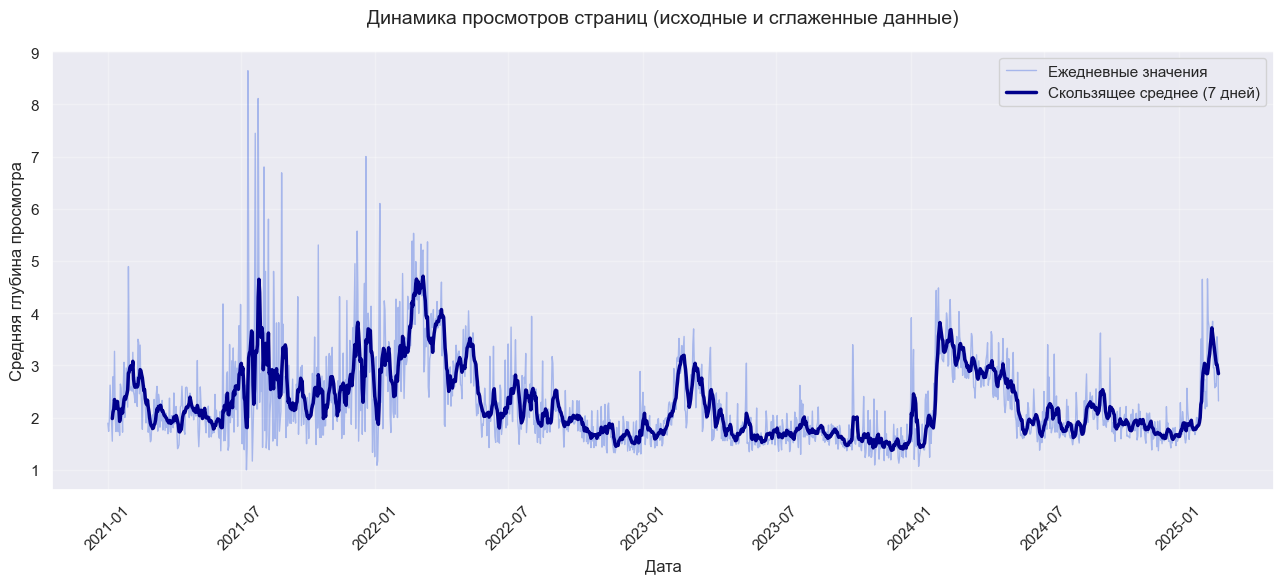

In [39]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(13, 6))
    
    daily_avg = data.groupby("date")["pageViews"].mean()
    
    # Сглаживание скользящим средним
    window_size = 7
    smoothed_views = daily_avg.rolling(window=window_size).mean()
    
    plt.plot(daily_avg.index, daily_avg.values, 
             linewidth=1, color='royalblue', alpha=0.4, label='Ежедневные значения')
    plt.plot(smoothed_views.index, smoothed_views.values, 
             linewidth=2.5, color='darkblue', label=f'Скользящее среднее ({window_size} дней)')
    
    plt.ylabel("Средняя глубина просмотра", fontsize=12)
    plt.xlabel("Дата", fontsize=12)
    plt.title("Динамика просмотров страниц (исходные и сглаженные данные)", fontsize=14, pad=20)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Анализ динамики пользовательской активности

Наблюдается устойчивый рост количества уникальных пользователей платформы с течением времени. Данные демонстрируют выраженную сезонную составляющую:

- **Пиковые периоды активности:** февраль-март и сентябрь-октябрь
- **Сезонный спад:** апрель характеризуется снижением пользовательской активности по сравнению с весенним пиком

### Оценка минимального размера выборки

Для консервативной оценки принимаем, что в течение апреля платформу посетит **не менее 8,000 уникальных пользователей**. Эта оценка основана на анализе исторических данных и учитывает сезонные колебания трафика.

## Анализ мощности A/B теста

### Бизнес-ограничения и параметры теста
Предположим, что у нас стоит строгое бизнес-ограничение — определить наличие эффекта в течение одного месяца. В таком случае мы не можем проводить тест дольше, поэтому фиксируем его длительность.

**Параметры эксперимента:**
- Длительность теста: **T = 28 дней** (для соблюдения недельной и месячной периодичности)
- Размер тестовой и контрольной групп: **10,000 уникальных пользователей**
- Распределение: **50% в тест, 50% в контроль**
- Целевая метрика: **глубина просмотра (pageViews)**

### Методология оценки мощности
Построим график мощности для определения минимального детектируемого эффекта. На заданной мощности 0.8 мы сможем оценить, какие изменения метрики можем статистически значимо зафиксировать.

*Примечание:* При текущих ограничениях возможно, что 5% изменение не будет детектироваться на требуемой мощности.

In [50]:
test_control_users = 10_000  # количество пользователей в тесте и контроле
test_group_fraction = 0.5    # доля пользователей в тестовой группе

# Период для валидации
validation_start_date = pd.to_datetime("2025-01-01")
validation_end_date = pd.to_datetime("2025-02-28")
# Длительность эксперимента
experiment_duration = 28
# Целевой показатель
target_metric = "pageViews"

# Эффекты для анализа мощности
effect_sizes = np.linspace(0, 0.15, 16)

iterations_count = 1_000  # число итераций симуляции
significance_level = 0.05  # уровень статистической значимости
parallel_processes = 4     # количество параллельных процессов

## Валидация статистических критериев на исторических данных

---

### Методология валидации абсолютного и относительного t-test

Проведем комплексную валидацию статистических критериев на исторических данных с соблюдением временных границ доступного периода. На основе предыдущего анализа данных ограничим исторический период для обеспечения репрезентативности выборок.

#### Поэтапный алгоритм валидации

**Этап 1: Валидация корректности критериев (A/A тесты)**

a. Процедура многократного тестирования:
1. **Случайный выбор даты начала** - равномерное распределение в пределах доступного периода
2. **Формирование выборки** - отбор следующих 10,000 уникальных пользователей после выбранной даты
3. **Рандомизация групп** - случайное распределение пользователей на тестовую и контрольную группы (50/50)
4. **Применение критерия** - расчет p-value с использованием тестируемого критерия

b. Статистическая оценка:
- Расчет частоты отвержения нулевой гипотезы
- Построение доверительного интервала для вероятности ошибки I рода
- **Критерий корректности:** теоретический уровень значимости α = 0.05 должен попадать в доверительный интервал

**Этап 2: Оценка мощности критериев (A/B тесты с искусственным эффектом)**

a. Процедура для каждого размера эффекта:
1. **Случайный выбор даты начала** - аналогично этапу 1
2. **Формирование выборки** - отбор 10,000 уникальных пользователей
3. **Рандомизация групп** - случайное распределение (50% тест, 50% контроль)
4. **Введение эффекта** - умножение значений метрики в тестовой группе на (1 + effect)
5. **Статистический тест** - применение критерия к модифицированным данным

b. Анализ мощности:
- Расчет мощности как доли отвержений нулевой гипотезы
- Построение доверительных интервалов для оценки мощности
- Определение MDE (Minimum Detectable Effect) для мощности 80%

#### Ограничения и допущения

- **Временные границы:** тестовые периоды не выходят за пределы доступных исторических данных
- **Размер выборки:** 10,000 пользователей обеспечивает достаточную мощность для детектирования разумных эффектов
- **Сезонность:** случайный выбор дат минимизирует влияние сезонных факторов
- **Эффект вмешательства:** искусственное добавление эффекта имитирует реальное воздействие

Напишем абсолютный t-test.

In [51]:
def independent_ttest(sample_a, sample_b):
    """
    T-тест для независимых выборок.

    Параметры:
    sample_a, sample_b -- выборки одинакового размера
    
    Возвращает:
    test_statistic -- значение статистики теста
    p_value -- p-значение
    confidence_lower, confidence_upper -- границы доверительного интервала
    """
    test_result = sps.ttest_ind(sample_a, sample_b)
    test_statistic = test_result.statistic
    p_value = test_result.pvalue
    confidence_lower, confidence_upper = test_result.confidence_interval()
    
    return test_statistic, p_value, confidence_lower, confidence_upper

In [52]:
def relative_ttest_independent(sample_a, sample_b, alpha_level=0.05):
    """
    Относительный t-тест для независимых выборок.

    Параметры:
    sample_a, sample_b -- выборки одинакового размера
    alpha_level -- уровень статистической значимости

    Возвращает:
    test_statistic -- значение статистики теста
    p_value -- p-значение
    confidence_lower, confidence_upper -- границы доверительного интервала
    """
    sample_size = len(sample_a)
    mean_a = sample_a.mean()
    mean_b = sample_b.mean()

    relative_effect = mean_a / mean_b - 1
    variance = (sample_a.var() / (mean_b ** 2) + 
                sample_b.var() * (mean_a ** 2) / (mean_b ** 4))
    std_error = np.sqrt(variance)

    z_score = np.sqrt(sample_size) * relative_effect / std_error
    p_value = 2 * sps.norm.sf(np.abs(z_score))

    critical_value = sps.norm.ppf(1 - alpha_level / 2)
    confidence_lower = relative_effect - critical_value * std_error / np.sqrt(sample_size)
    confidence_upper = relative_effect + critical_value * std_error / np.sqrt(sample_size)

    return relative_effect, p_value, confidence_lower, confidence_upper

In [53]:
def calculate_rejection_probability(rejections_count, total_iterations):
    """
    Расчет вероятности отвержения нулевой гипотезы и доверительного интервала.
    Используется для оценки вероятности ошибки I рода и мощности критерия.

    Параметры:
    rejections_count -- количество отвержений H0 в эксперименте
    total_iterations -- общее количество экспериментов

    Возвращает:
    rejection_prob -- оценка вероятности отвержения критерия
    confidence_lower, confidence_upper -- границы доверительного интервала
    """
    rejection_prob = rejections_count / total_iterations
    confidence_lower, confidence_upper = proportion_confint(
        rejections_count, total_iterations, method="wilson"
    )

    return rejection_prob, confidence_lower, confidence_upper


def plot_rejection_analysis(
    rejection_probability,
    confidence_lower,
    confidence_upper,
    show_pvalues=False,
    pvalues_data=None,
    alpha_level=0.05,
    figure_size=(12, 4),
    plot_title=None,
):
    """
    Визуализация доверительного интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально).

    Параметры:
    rejection_probability -- оценка вероятности отвержения
    confidence_lower, confidence_upper -- границы доверительного интервала
    alpha_level -- теоретическая вероятность ошибки первого рода
    show_pvalues -- отображать ли распределение p-value
    pvalues_data -- массив p-value
    figure_size -- размер графика matplotlib
    """

    if show_pvalues:
        figure, (hist_axis, interval_axis) = plt.subplots(1, 2, figsize=figure_size)
        
        # Гистограмма p-value
        hist_axis.hist(
            pvalues_data,
            bins=np.linspace(0, 1, 21),
            alpha=0.7,
            color='lightblue',
            edgecolor='navy',
            weights=np.ones(len(pvalues_data)) / len(pvalues_data),
        )
        hist_axis.set_xlabel("p-value", fontsize=11)
        hist_axis.set_ylabel("Доля экспериментов", fontsize=11)
        hist_axis.set_title("Распределение p-value", fontsize=12)
        hist_axis.grid(True, alpha=0.3)
        
        plt.sca(interval_axis)
    else:
        plt.figure(figsize=figure_size)

    # Отрисовка доверительного интервала
    plt.hlines(0, 0, 1, color="gray", linewidth=3, alpha=0.8)
    plt.vlines(
        alpha_level, -0.2, 0.2, 
        color="red", linewidth=4, linestyle="--", 
        alpha=0.8, label=f'α = {alpha_level}'
    )
    plt.fill_between(
        [confidence_lower, confidence_upper], [0.12] * 2, [-0.12] * 2, 
        color="lightgreen", alpha=0.5, label='Доверительный интервал'
    )
    plt.scatter(
        rejection_probability, 0, 
        s=200, marker="D", color="darkred", 
        edgecolor='black', label='Точечная оценка'
    )
    
    x_min = min(alpha_level, confidence_lower) - 0.02
    x_max = max(alpha_level, confidence_upper) + 0.02
    plt.xlim((x_min, x_max))
    
    plt.title(
        f"Вероятность отвержения H₀\n"
        f"{100*rejection_probability:.2f}% [{100*confidence_lower:.2f}%, {100*confidence_upper:.2f}%]",
        fontsize=12
    )
    
    if plot_title:
        plt.suptitle(plot_title, fontsize=14, y=1.02)
    
    plt.ylim((-0.3, 0.3))
    plt.yticks([])
    plt.xlabel("Вероятность отвержения", fontsize=11)
    plt.legend(loc='upper right', frameon=True)
    plt.grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()


def plot_power_curve(
    power_values,
    power_lower_bounds,
    power_upper_bounds,
    effect_sizes=np.linspace(0, 0.1, 11),
    curve_label=None,
    plot_title="График мощности критерия",
    create_new_figure=False,
):
    """
    Построение и отрисовка кривой мощности критерия.

    Параметры:
    power_values -- значения мощности критерия
    power_lower_bounds, power_upper_bounds -- границы доверительных интервалов
    effect_sizes -- сетка размеров эффекта
    curve_label -- метка для легенды
    plot_title -- заголовок графика
    create_new_figure -- создавать новый график
    """

    if create_new_figure:
        plt.figure(figsize=(10, 5))

    plt.plot(
        effect_sizes, power_values, 
        label=curve_label, linewidth=3, 
        marker='s', markersize=6
    )
    plt.fill_between(effect_sizes, power_lower_bounds, power_upper_bounds, alpha=0.2)

    if create_new_figure:
        plt.hlines(
            0.8,
            effect_sizes[0],
            effect_sizes[-1],
            color="red",
            linestyle='--',
            alpha=0.7,
            label="Мощность 0.8",
            linewidth=2
        )
        plt.xlabel("Размер относительного эффекта", fontsize=12)
        plt.ylabel("Мощность критерия", fontsize=12)
        plt.title(plot_title, fontsize=14, pad=15)
        
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)

In [57]:
def apply_treatment_effect(
    sample_data, 
    effect_size, 
    target_column="pilot", 
    relative_effect=True
):
    """
    Применение искусственного эффекта к тестовой выборке.

    Параметры:
    sample_data -- исходная выборка данных
    effect_size -- величина применяемого эффекта
    target_column -- название колонки с целевой метрикой
    relative_effect -- тип эффекта (относительный/абсолютный)

    Возвращает:
    modified_sample -- выборка с примененным эффектом
    """
    sample_copy = sample_data.copy()
    if relative_effect:
        sample_copy[target_column] *= 1 + effect_size
    else:
        sample_copy[target_column] += effect_size

    return sample_copy

def run_single_iteration(
    statistical_test,
    sample_generator,
    target_column,
    effect_applier,
    effect_sizes=[0],
    relative_effect=True,
):
    """
    Выполнение одной итерации A/A теста на синтетических выборках.

    Параметры:
    statistical_test -- статистический критерий для сравнения
    sample_generator -- функция генерации выборок
    effect_applier -- функция применения эффекта
    effect_sizes -- список размеров эффектов для оценки мощности
    relative_effect -- тип эффекта (относительный/абсолютный)

    Возвращает: массив p-значений
    """
    # Генерация выборок
    control_sample, test_sample = sample_generator(data=data)

    p_values = []
    for effect in effect_sizes:
        # Применение эффекта для оценки мощности
        modified_sample = effect_applier(
            control_sample, effect, target_column=target_column, relative_effect=relative_effect
        )
        # Применение статистического критерия
        p_values.append(statistical_test(modified_sample, test_sample)[1])
    return p_values

def execute_experiments(
    statistical_test,
    sample_generator,
    data=None,
    effect_applier=apply_treatment_effect,
    iterations_count=10000,
    sample_size=1000,
    effect_magnitude=0,
    relative_effect=True,
    parallel_jobs=4,
    alpha_level=0.05,
    target_column="pilot",
    create_plot=False,
    plot_title=None,
    show_pvalues=True,
):
    """
    Проведение серии A/A тестов на исторических данных.

    Параметры:
    statistical_test -- статистический критерий
    sample_generator -- функция генерации выборок
    data -- исторические данные
    iterations_count -- количество итераций эксперимента
    sample_size -- размер генерируемых выборок
    effect_applier -- функция применения эффекта
    effect_magnitude -- величина применяемого эффекта
    relative_effect -- тип эффекта (относительный/абсолютный)
    alpha_level -- уровень статистической значимости
    target_column -- название колонки с целевой метрикой
    create_plot -- флаг отображения графиков
    plot_title -- заголовок для графика
    show_pvalues -- отображать ли распределение p-значений
    """

    # Параллельное выполнение экспериментов
    pvalues_results = Parallel(n_jobs=parallel_jobs)(
        delayed(run_single_iteration)(
            statistical_test, sample_generator, target_column, effect_applier, 
            [effect_magnitude], relative_effect
        )
        for _ in tqdm(range(iterations_count), leave=False)
    )
    pvalues_results = np.array(pvalues_results).flatten()
    
    # Подсчет количества отвержений нулевой гипотезы
    rejection_count = (pvalues_results < alpha_level).sum()

    # Расчет вероятности отвержения
    rejection_prob, confidence_lower, confidence_upper = calculate_rejection_probability(
        rejection_count, iterations_count
    )

    # Визуализация результатов
    if create_plot:
        figure_size = (14, 3) if show_pvalues else (5, 2)
        plot_rejection_analysis(
            rejection_prob,
            confidence_lower,
            confidence_upper,
            show_pvalues,
            pvalues_results,
            alpha_level,
            figure_size,
            plot_title,
        )

    return rejection_prob, (confidence_lower, confidence_upper)

def calculate_power_curve(
    statistical_test,
    sample_generator,
    data=None,
    parallel_jobs=4,
    iterations_count=10000,
    sample_size=1000,
    effect_sizes=np.linspace(0, 0.1, 11),
    relative_effect=True,
    alpha_level=0.05,
    target_column="pilot",
):
    """
    Оценка мощности критерия при различных размерах эффекта.

    Параметры:
    statistical_test -- статистический критерий
    sample_generator -- функция генерации выборок
    data -- исторические данные
    parallel_jobs -- количество параллельных процессов
    iterations_count -- количество итераций
    sample_size -- размер выборок
    effect_sizes -- диапазон эффектов для анализа мощности
    relative_effect -- тип эффекта (относительный/абсолютный)
    alpha_level -- уровень значимости
    target_column -- название колонки с целевой метрикой
    """
    # Параллельное выполнение экспериментов
    pvalues_matrix = Parallel(n_jobs=parallel_jobs)(
        delayed(run_single_iteration)(
            statistical_test,
            sample_generator,
            target_column,
            apply_treatment_effect,
            effect_sizes,
            relative_effect,
        )
        for _ in tqdm(range(iterations_count), leave=False)
    )

    # Подсчет отвержений для каждого размера эффекта
    rejection_counts = (np.array(pvalues_matrix) < alpha_level).sum(axis=0)

    # Расчет мощности и доверительных интервалов
    power_values, power_lower_bounds, power_upper_bounds = calculate_rejection_probability(
        rejection_counts, iterations_count
    )

    return power_values, power_lower_bounds, power_upper_bounds

Напишем функцию, отбирающую исторические данные и делящую выборку на тест и контроль.

In [58]:
def generate_experiment_samples(
    data,
    validation_start_date=validation_start_date,
    validation_end_date=validation_end_date,
    experiment_duration=experiment_duration,
    total_sample_size=test_control_users,
    test_group_fraction=test_group_fraction,
    date_column="date",
    user_id_column="clientID",
    target_metric_column="pageViews",
):
    """
    Генерация выборок для тестовой и контрольной групп путем случайного разделения пользователей.
    Агрегация данных на уровне пользователей.

    Параметры:
    data -- исходный набор данных
    validation_start_date, validation_end_date -- временные границы периода валидации
    experiment_duration -- длительность экспериментального периода в днях
    total_sample_size -- общее количество пользователей в тесте и контроле
    test_group_fraction -- доля пользователей в тестовой группе

    Возвращает:
    test_group_aggregated, control_group_aggregated -- агрегированные данные по группам
    """
    # Определение временных границ эксперимента
    total_days_range = (validation_end_date - validation_start_date).days - experiment_duration
    random_day_offset = np.random.choice(total_days_range, 1)[0]
    experiment_start_date = validation_start_date + pd.to_timedelta(random_day_offset, "D")
    experiment_end_date = experiment_start_date + pd.to_timedelta(experiment_duration, "D")

    # Выбор данных за период эксперимента
    experiment_period_data = data[
        (data[date_column] >= experiment_start_date) & 
        (data[date_column] < experiment_end_date)
    ]

    # Случайное разделение пользователей на тестовую и контрольную группы
    unique_users = experiment_period_data[user_id_column].unique()
    test_group_size = int(total_sample_size * test_group_fraction)
    control_group_size = total_sample_size - test_group_size
    
    test_group_users = np.random.choice(unique_users, test_group_size, replace=False)
    remaining_users = list(set(unique_users) - set(test_group_users))
    control_group_users = np.random.choice(
        remaining_users, min(control_group_size, len(remaining_users)), replace=False
    )

    # Фильтрация данных по группам пользователей
    test_group_data = experiment_period_data[experiment_period_data[user_id_column].isin(test_group_users)]
    control_group_data = experiment_period_data[experiment_period_data[user_id_column].isin(control_group_users)]

    # Агрегация данных на уровне пользователей
    aggregation_config = {target_metric_column: "mean"}
    test_group_aggregated = test_group_data.groupby(user_id_column).agg(aggregation_config)
    control_group_aggregated = control_group_data.groupby(user_id_column).agg(aggregation_config)

    return test_group_aggregated, control_group_aggregated

### 2.1. Проверка абсолютного и относительного теста на корректность и оценка их мощности

Корректность

Выполняется Абсолютный t-тест:


  0%|          | 0/1000 [00:00<?, ?it/s]

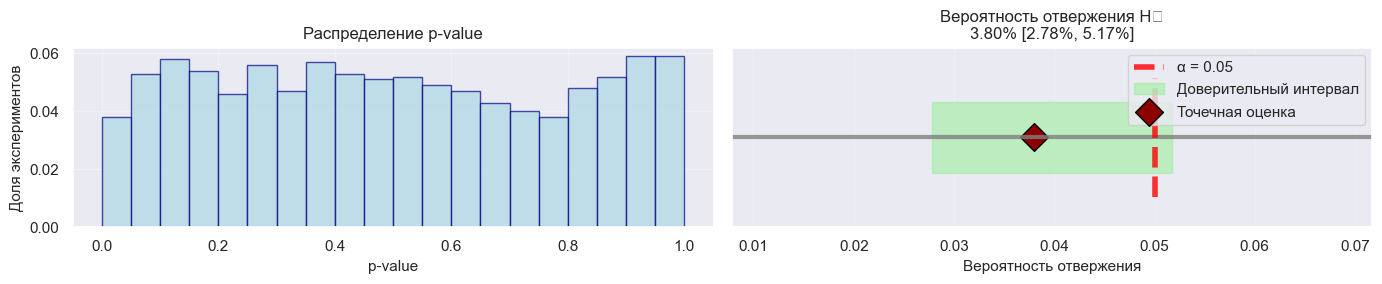


Выполняется Относительный t-тест:


  0%|          | 0/1000 [00:00<?, ?it/s]

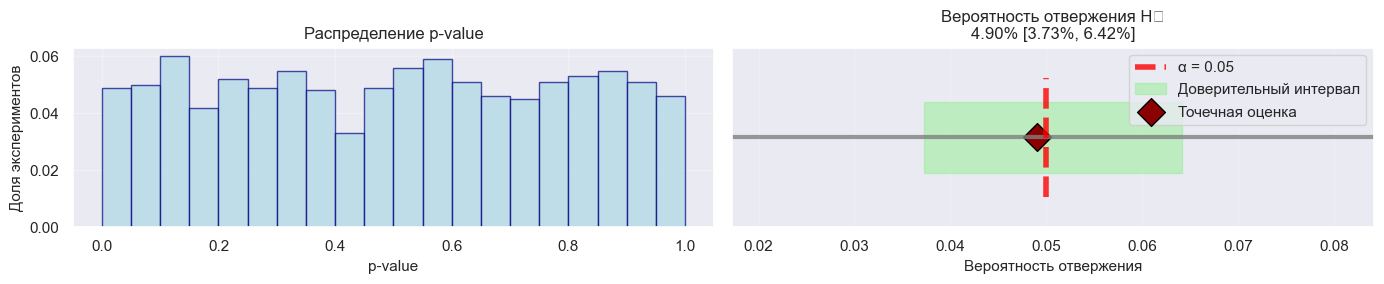

In [59]:
statistical_tests = [
    lambda sample_a, sample_b: independent_ttest(sample_a[target_metric], sample_b[target_metric]),
    lambda sample_a, sample_b: relative_ttest_independent(sample_a[target_metric], sample_b[target_metric]),
]

test_names = ["Абсолютный t-тест", "Относительный t-тест"]

for statistical_test, test_name in zip(statistical_tests, test_names):
    print(f"Выполняется {test_name}:")
    execute_experiments(
        statistical_test=statistical_test,
        sample_generator=generate_experiment_samples,
        target_column=target_metric,
        data=data,
        iterations_count=iterations_count,
        alpha_level=significance_level,
        show_pvalues=True,
        create_plot=True,
        parallel_jobs=parallel_processes,
    )
    print()

Мощность

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

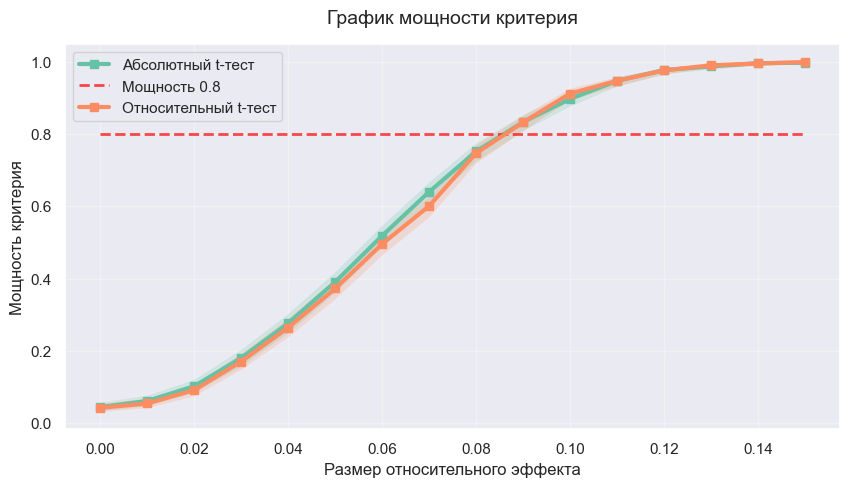

In [61]:
statistical_tests = [
    lambda sample_a, sample_b: independent_ttest(sample_a[target_metric], sample_b[target_metric]),
    lambda sample_a, sample_b: relative_ttest_independent(sample_a[target_metric], sample_b[target_metric]),
]

test_names = ["Абсолютный t-тест", "Относительный t-тест"]

for test_index, (statistical_test, test_name) in enumerate(zip(statistical_tests, test_names)):
    power_values, power_lower_bounds, power_upper_bounds = calculate_power_curve(
        statistical_test=statistical_test,
        sample_generator=generate_experiment_samples,
        target_column=target_metric,
        effect_sizes=effect_sizes,
        data=data,
        iterations_count=iterations_count,
        alpha_level=significance_level,
        parallel_jobs=parallel_processes,
    )
    plot_power_curve(
        power_values,
        power_lower_bounds,
        power_upper_bounds,
        effect_sizes=effect_sizes,
        curve_label=test_name,  
        create_new_figure=(test_index == 0),
    )

Результаты анализа: Оба статистических теста демонстрируют корректное поведение. Абсолютный t-тест достигает достаточной мощности (0.8) при относительном эффекте величиной 9%.

"""
### 2.2 Валидация регрессионных тестов и оценка статистической мощности

---

Проведение сравнительного анализа различных методов снижения дисперсии:

1. **Стратификация по операционным системам**
   - Группировка пользователей по типам операционных систем
   - Объединение редко встречающихся ОС в общую категорию
   - Исключение малых страт при необходимости

2. **Метод CUPED со стандартной ковариатой**
   - Использование предэкспериментальных значений метрики в качестве ковариаты
   - Обработка новых пользователей через бинарный признак наличия исторической активности
   - Замена отсутствующих значений константой для пользователей без истории
   - Комбинирование со стратификацией по дополнительному категориальному признаку

3. **Комбинированный подход**
   - Объединение стратификации по ОС с методом CUPED
   - Синергетический эффект двух методов снижения дисперсии

4. **Расширенный CUPED с дополнительными ковариатами**
   - Включение дополнительных переменных в регрессионную модель
   - Использование доступных признаков пользователей для улучшения точности

5. **ML-усиленный CUPED**
   - Применение машинного обучения для прогнозирования целевой метрики
   - Использование предсказаний ML-модели в качестве ковариаты
   - Учет множественных признаков для более точной корректировки

---

Реализуем функцию генерации данных с подсчетом стратификационных данных и ковариат (в том числе — и предсказанных).

In [107]:
# Вещественные признаки для построения моделей
numerical_features = [
    "prepilot",
    "windowClientWidth",
    "windowClientHeight",
]

# Категориальные признаки для построения моделей
categorical_features = [
    "has_prepilot",
    "operatingSystemRoot",
    "browser",
    "regionCountry",
    "screenOrientation",
    "networkType",
]


def generate_samples_with_covariates(
    data,
    aggregation_config,
    validation_start_date=validation_start_date,
    validation_end_date=validation_end_date,
    experiment_duration=experiment_duration,
    total_sample_size=test_control_users,
    test_group_fraction=test_group_fraction,
    date_column="date",
    user_id_column="clientID",
    target_metric_column="pageViews",
    numerical_features=numerical_features,
    categorical_features=categorical_features,
    ml_model=CatBoostRegressor(n_estimators=100, cat_features=categorical_features, verbose=False),
    use_cuped=False,
    use_cupac=False,
):
    """
    Генерация выборок для тестовой и контрольной групп со сбором ковариат.
    Случайное разделение пользователей на две группы и агрегация данных.

    Параметры:
    data -- исходный набор данных
    aggregation_config -- словарь агрегации для группировки
    validation_start_date, validation_end_date -- временные границы валидации
    experiment_duration -- длительность экспериментального периода
    total_sample_size -- общее количество пользователей в эксперименте
    test_group_fraction -- доля пользователей в тестовой группе
    use_cuped -- флаг применения метода CUPED
    use_cupac -- флаг применения метода CUPAC

    Возвращает:
    test_group_aggregated, control_group_aggregated -- агрегированные данные по группам
    """

    # Определение временных границ эксперимента
    total_days_range = (validation_end_date - validation_start_date).days - experiment_duration
    random_day_offset = np.random.choice(total_days_range, 1)[0]
    experiment_start_date = validation_start_date + pd.to_timedelta(random_day_offset, "D")
    experiment_end_date = experiment_start_date + pd.to_timedelta(experiment_duration, "D")

    # Выбор данных за период эксперимента
    experiment_period_data = data[
        (data[date_column] >= experiment_start_date) & 
        (data[date_column] < experiment_end_date)
    ]

    # Случайное разделение пользователей на группы
    unique_users = experiment_period_data[user_id_column].unique()
    test_group_size = int(total_sample_size * test_group_fraction)
    control_group_size = total_sample_size - test_group_size
    
    test_group_users = np.random.choice(unique_users, test_group_size, replace=False)
    remaining_users = list(set(unique_users) - set(test_group_users))
    control_group_users = np.random.choice(
        remaining_users, min(control_group_size, len(remaining_users)), replace=False
    )

    # Фильтрация данных по группам пользователей
    test_group_data = experiment_period_data[experiment_period_data[user_id_column].isin(test_group_users)]
    control_group_data = experiment_period_data[experiment_period_data[user_id_column].isin(control_group_users)]

    # Агрегация данных на уровне пользователей
    test_group_aggregated = test_group_data.groupby(user_id_column).agg(aggregation_config)
    control_group_aggregated = control_group_data.groupby(user_id_column).agg(aggregation_config)

    # Применение методов снижения дисперсии
    if use_cuped:
        test_group_aggregated = count_prepilot_metric(
            data,
            test_group_aggregated,
            experiment_start_date,
            test_dlit=experiment_duration,
            date_column=date_column,
            user_column=user_id_column,
            target_column=target_metric_column,
        )
        control_group_aggregated = count_prepilot_metric(
            data,
            control_group_aggregated,
            experiment_start_date,
            test_dlit=experiment_duration,
            date_column=date_column,
            user_column=user_id_column,
            target_column=target_metric_column,
        )

        return test_group_aggregated, control_group_aggregated
        
    if use_cupac:
        return calculate_cupac_metric(
            data,
            aggregation_config,
            test_group_aggregated,
            control_group_aggregated,
            experiment_start_date,
            experiment_duration=experiment_duration,
            date_column=date_column,
            user_id_column=user_id_column,
            target_metric_column=target_metric_column,
            numerical_features=numerical_features,
            categorical_features=categorical_features,
            ml_model=ml_model,
        )
        
    return test_group_aggregated, control_group_aggregated

Функция подсчета метрики на препилоте

In [122]:
def count_prepilot_metric(
    data,
    group,
    start_date,
    test_dlit=28,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
):
    """
    Считаем метрику на препилоте

    Аргументы:
    data -- данные
    group -- сгруппированные данные
    start_date -- дата старта теста
    test_dlit -- длительность истории, которую берем в тест

    Возвращает:
    group -- сгруппированные данные c метрикой на препилоте
    """

    # берем нужный срез по датам
    prepilot_start_date = start_date - pd.to_timedelta(test_dlit, "D")
    prepilot_end_date = start_date - pd.to_timedelta(1, "D")

    prepilot = data[
        (data[date_column] >= prepilot_start_date)
        & (data[date_column] < prepilot_end_date)
    ]

    # берем нужный срез по пользователям
    users = group.index.unique()
    prepilot_group = prepilot[prepilot[user_column].isin(users)]

    # группируем данные
    prepilot_groupped = prepilot_group.groupby(user_column)[[target_column]].mean()

    # заполняем данными препилота
    group["prepilot"] = prepilot_groupped[target_column]
    group["has_prepilot"] = group["prepilot"].apply(lambda x: 0 if pd.isnull(x) else 1)
    group["prepilot"] = group["prepilot"].fillna(0)

    return group

Сбор данных для трейна модели предсказания для CUPAC

In [109]:
def collect_train_for_cupac(
    data,
    agg_dict,
    start_date,
    test_dlit=28,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
):
    """
    Собираем данные трейна для метода СUPAC

    Аргументы:
    data -- данные
    start_date -- дата старта теста
    test_dlit -- длительность истории, которую берем в тест

    Возвращает:
    prepilot_groupped -- сгруппированные данные препилота для обучения СUPAC
    """
    # берем нужный срез препилота по времени
    prepilot_start_date = start_date - pd.to_timedelta(test_dlit, "D")
    prepilot_end_date = start_date - pd.to_timedelta(1, "D")
    prepilot = data[
        (data[date_column] >= prepilot_start_date)
        & (data[date_column] < prepilot_end_date)
    ]

    # агрегируем данные
    prepilot_groupped = prepilot.groupby(user_column).agg(agg_dict)
    # добавляем данные препилота
    prepilot_groupped = count_prepilot_metric(
        data,
        prepilot_groupped,
        prepilot_start_date,
        test_dlit,
        date_column=date_column,
        user_column=user_column,
        target_column=target_column,
    )
    return prepilot_groupped

Функция подсчета предсказания, чтобы использовать CUPAC

In [119]:
def calculate_cupac_metric(
    data,
    aggregation_config,
    test_group_aggregated,
    control_group_aggregated,
    experiment_start_date,
    experiment_duration=28,
    date_column="date",
    user_id_column="clientID",
    target_metric_column="pageViews",
    numerical_features=None,
    categorical_features=None,
    ml_model=None,
):
    """
    Расчет CUPAC-метрики (Covariates Using Pre-Experiment Data and Additional Covariates).

    Параметры:
    data -- исходный набор данных
    aggregation_config -- словарь агрегации для группировки
    test_group_aggregated, control_group_aggregated -- агрегированные данные групп
    experiment_start_date -- дата начала эксперимента
    experiment_duration -- длительность экспериментального периода
    date_column -- название колонки с датой
    user_id_column -- название колонки с идентификатором пользователя
    target_metric_column -- название колонки с целевой метрикой
    numerical_features -- список вещественных признаков
    categorical_features -- список категориальных признаков
    ml_model -- модель машинного обучения для прогнозирования

    Возвращает:
    test_group_with_cupac, control_group_with_cupac -- данные с рассчитанными CUPAC-метриками
    """
    
    # Установка значений по умолчанию
    if numerical_features is None:
        numerical_features = [
            "prepilot",
            "windowClientWidth", 
            "windowClientHeight",
        ]
    
    if categorical_features is None:
        categorical_features = [
            "has_prepilot",
            "operatingSystemRoot",
            "browser",
            "regionCountry",
            "screenOrientation", 
            "networkType",
        ]
    
    if ml_model is None:
        ml_model = CatBoostRegressor(
            n_estimators=200, 
            cat_features=categorical_features, 
            verbose=False
        )
    
    # Добавление препилот-метрик к тестовой и контрольной группам
    test_group_aggregated = count_prepilot_metric(
        data,
        test_group_aggregated,
        experiment_start_date,
        test_dlit=experiment_duration,
        date_column=date_column,
        user_column=user_id_column,
        target_column=target_metric_column,
    )
    control_group_aggregated = count_prepilot_metric(
        data,
        control_group_aggregated,
        experiment_start_date,
        test_dlit=experiment_duration,
        date_column=date_column,
        user_column=user_id_column,
        target_column=target_metric_column,
    )
    
    # Сбор обучающих данных для ML-модели
    training_data = collect_train_for_cupac(
        data,
        aggregation_config,
        experiment_start_date,
        test_dlit=experiment_duration,
        date_column=date_column,
        user_column=user_id_column,
        target_column=target_metric_column,
    )

    # Формирование списка признаков для модели
    feature_columns = numerical_features + categorical_features

    # Обучение модели на тренировочных данных
    ml_model.fit(training_data[feature_columns], training_data[target_metric_column])

    # Прогнозирование для тестовой и контрольной групп
    test_group_aggregated["model_predicted"] = ml_model.predict(test_group_aggregated[feature_columns])
    control_group_aggregated["model_predicted"] = ml_model.predict(control_group_aggregated[feature_columns])

    return test_group_aggregated, control_group_aggregated

Регрессионный t-test. Есть возможность сделать стратификацию, CUPED и CUPAC по нескольким колонкам

In [120]:
def regression_ttest(
    x_data,
    y_data,
    cuped=False,
    stratified=False,
    sample_name="pilot",
    treatment_name="treatment",
    covariate_names=[],
    strat_names=[],
):
    """
    T-test с CUPED/без CUPED, со стратификацией/без реализованный через линейную регрессию

    Аргументы:
    x, y -- выборки одинакового размера
    :param cuped: применять ли cuped
    :param stratified: применять ли стратификацию
    :param sample_name: имя столбца с целевым признаком
    :param covariate_names: массив имен столбцов-ковариат
    :param strat_names: массив имен стратификационных столбцов

    Возвращает:
    stat -- статистика критерия
    pvalue
    left_bound, right_bound -- границы дов. интервала
    """

    x_data_copy = x_data.copy()
    y_data_copy = y_data.copy()

    # Добавляем столбец с индикатором тестовой группы
    x_data_copy[treatment_name] = 1
    y_data_copy[treatment_name] = 0
    
    # Объединяем тест и контроль в один датасет
    combined_data = pd.concat([x_data_copy, y_data_copy])
    
    # Удаляем ненужные столбцы из датасета
    if not cuped:
        covariate_names = []
    if not stratified:
        strat_names = []
        
    selected_columns = (
        [treatment_name] + 
        list(covariate_names) + 
        list(strat_names) + 
        [sample_name]
    )
    combined_data = combined_data[selected_columns]

    # Делаем стратификацию по нужным фичам
    combined_data = pd.get_dummies(combined_data, columns=strat_names)

    # Определяем имена фичей, на которых будем обучать модель
    feature_names = list(set(combined_data.columns) - set([sample_name]))

    # Обучаем модель
    regression_model = ols(
        f"{sample_name} ~ " + "+".join(feature_names), 
        data=combined_data
    ).fit()
    
    # Забираем таблицу с результатами
    results_summary = regression_model.summary2().tables[1]
    
    # Берем из таблицы нужные поля
    stat = results_summary.loc[treatment_name, "t"]
    pvalue = results_summary.loc[treatment_name, "P>|t|"]
    left_bound = results_summary.loc[treatment_name, "[0.025"]
    right_bound = results_summary.loc[treatment_name, "0.975]"]
    
    return stat, pvalue, left_bound, right_bound

Проведение валидации

Простой t-test


  0%|          | 0/1000 [00:00<?, ?it/s]

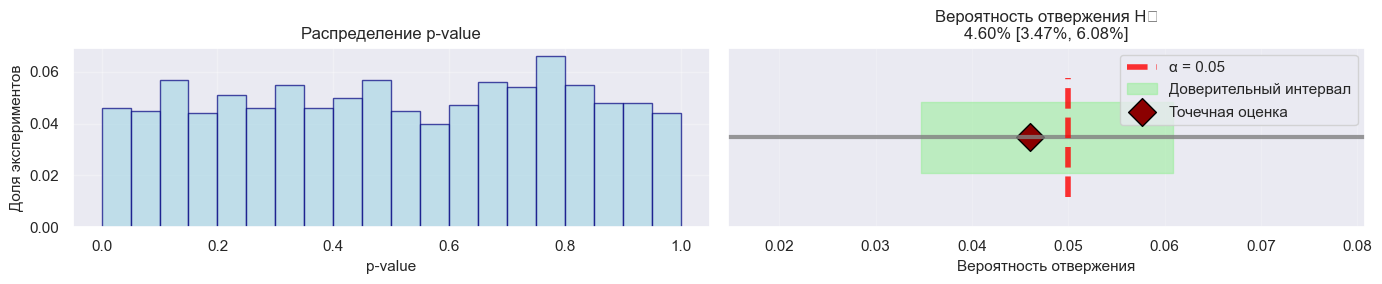

Стратификация по ОС


  0%|          | 0/1000 [00:00<?, ?it/s]

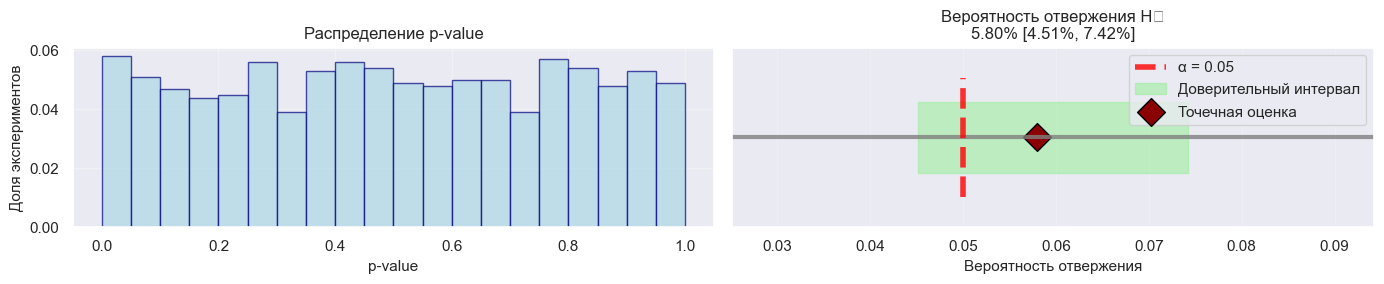

CUPED по препилоту


  0%|          | 0/1000 [00:00<?, ?it/s]

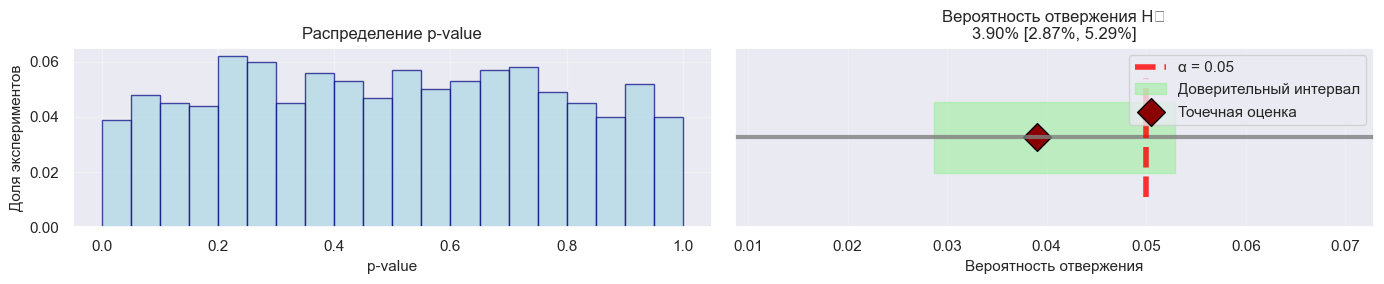

CUPED по нескольким ковариатам


  0%|          | 0/1000 [00:00<?, ?it/s]

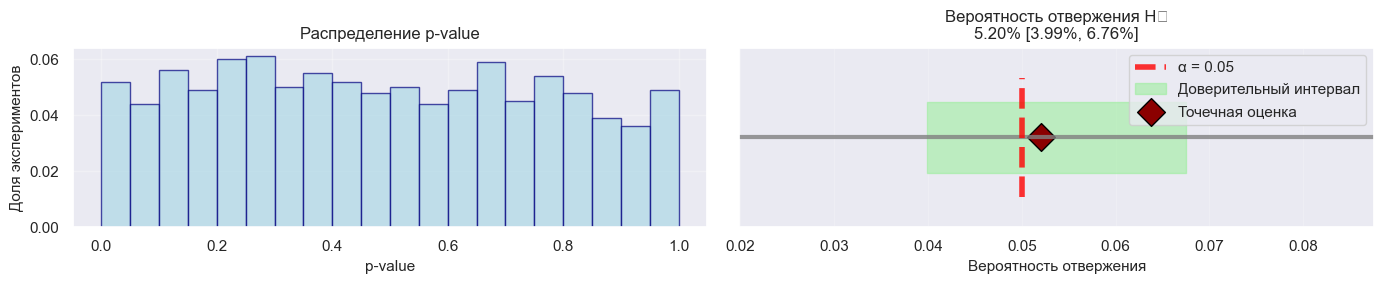

CUPAC: CatBoostRegressor


  0%|          | 0/1000 [00:00<?, ?it/s]

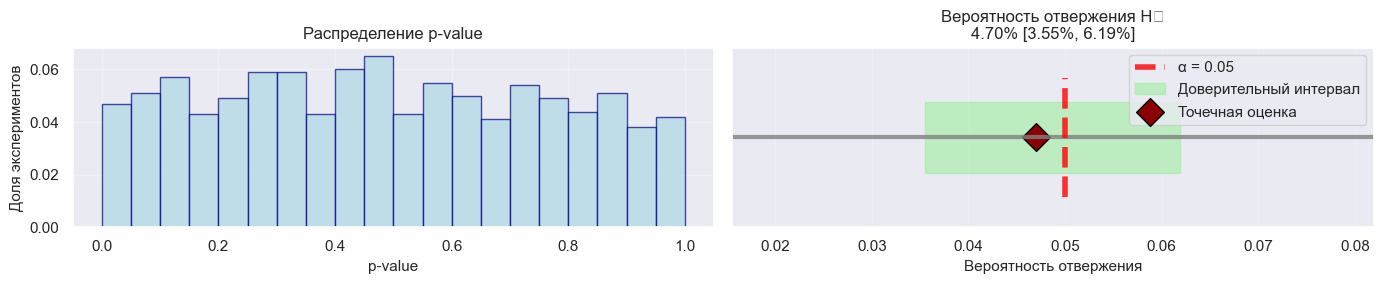

In [124]:
aggregation_config = {
    "pageViews": "mean",
    "operatingSystemRoot": lambda x: x.iloc[0],
    "browser": lambda x: x.iloc[0],
    "regionCountry": lambda x: x.iloc[0],
    "screenOrientation": lambda x: x.iloc[0],
    "networkType": lambda x: x.iloc[0],
    "siteType": lambda x: x.iloc[0],
    "windowClientWidth": "mean",
    "windowClientHeight": "mean",
}

tests = [
    lambda x, y: regression_ttest(
        x, y, cuped=False, stratified=False, sample_name="pageViews"
    ),
    lambda x, y: regression_ttest(
        x,
        y,
        cuped=False,
        stratified=True,
        strat_names=["operatingSystemRoot"],
        sample_name="pageViews",
    ),
    lambda x, y: regression_ttest(
        x,
        y,
        cuped=True,
        stratified=True,
        covariate_names=["prepilot"],
        strat_names=["has_prepilot"],
        sample_name="pageViews",
    ),
    lambda x, y: regression_ttest(
        x,
        y,
        cuped=True,
        stratified=True,
        covariate_names=["prepilot", "windowClientWidth", "windowClientHeight"],
        strat_names=[
            "has_prepilot",
            "operatingSystemRoot",
            "browser",
            "regionCountry",
            "screenOrientation",
            "networkType",
            "siteType",
        ],
        sample_name="pageViews",
    ),
    lambda x, y: regression_ttest(
        x, y, cuped=True, covariate_names=["model_predicted"], sample_name="pageViews"
    ),
]

generate_samples_list = [
    lambda data: generate_samples_with_covariates(data, aggregation_config=aggregation_config),
    lambda data: generate_samples_with_covariates(data, aggregation_config=aggregation_config),
    lambda data: generate_samples_with_covariates(data, aggregation_config=aggregation_config, use_cuped=True),
    lambda data: generate_samples_with_covariates(data, aggregation_config=aggregation_config, use_cuped=True),
    lambda data: generate_samples_with_covariates(data, aggregation_config=aggregation_config, use_cupac=True),
]

names = [
    "Простой t-test",
    "Стратификация по ОС",
    "CUPED по препилоту",
    "CUPED по нескольким ковариатам",
    "CUPAC: CatBoostRegressor",
]

for test, generate_samples, name in zip(tests, generate_samples_list, names):
    print(name)
    execute_experiments(
        statistical_test=test,
        sample_generator=generate_samples,
        target_column="pageViews",
        data=data,
        iterations_count=1000,
        alpha_level=0.05,
        show_pvalues=True,
        create_plot=True,
        parallel_jobs=4,
    )

Простой t-test


  0%|          | 0/1000 [00:00<?, ?it/s]

Стратификация по ОС


  0%|          | 0/1000 [00:00<?, ?it/s]

CUPED по препилоту


  0%|          | 0/1000 [00:00<?, ?it/s]

CUPED по нескольким ковариатам


  0%|          | 0/1000 [00:00<?, ?it/s]

CUPAC: CatBoostRegressor


  0%|          | 0/1000 [00:00<?, ?it/s]

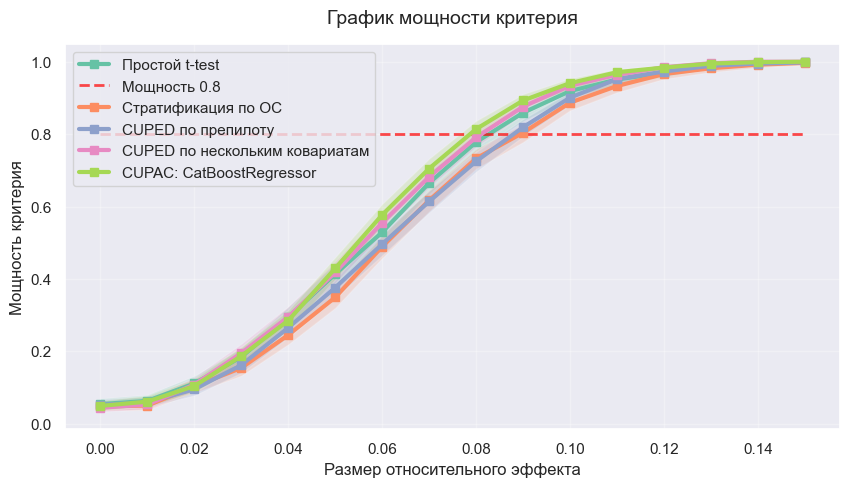

In [126]:
powers_list = []
left_bounds_list = []
right_bounds_list = []

for i, (test, generate_samples, name) in enumerate(
    zip(tests, generate_samples_list, names)
):
    print(name)
    powers, left_bounds, right_bounds = calculate_power_curve(
        statistical_test=test,
        sample_generator=generate_samples,
        target_column=target_metric,
        effect_sizes=effect_sizes,
        data=data,
        iterations_count=iterations_count,
        alpha_level=significance_level,
        parallel_jobs= parallel_processes,
    )
    powers_list.append(powers)
    left_bounds_list.append(left_bounds)
    right_bounds_list.append(right_bounds)
    plot_power_curve(
        powers,
        left_bounds,
        right_bounds,
        effect_sizes=effect_sizes,
        curve_label=name,
        create_new_figure=(i == 0),
    )

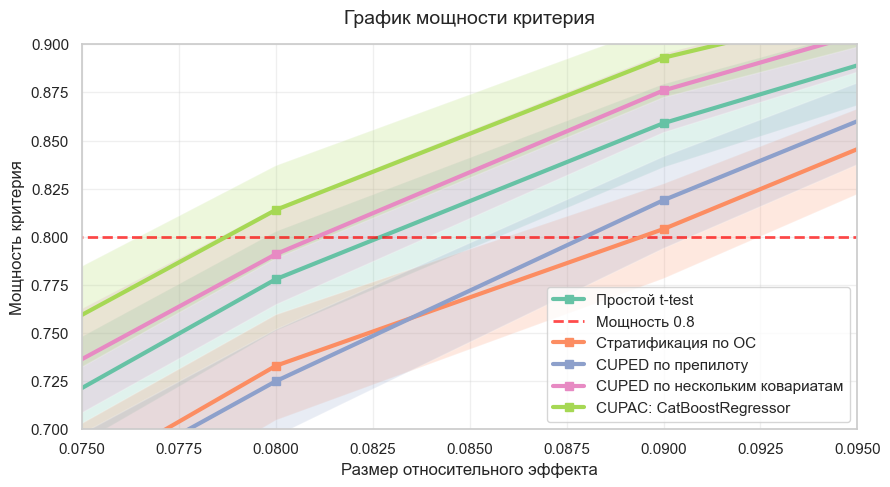

In [129]:
with sns.axes_style("whitegrid"):
    for i in range(len(tests)):
        plot_power_curve(
            powers_list[i],
            left_bounds_list[i],
            right_bounds_list[i],
            effect_sizes=effect_sizes,
            curve_label=names[i],
            create_new_figure=(i == 0),
        )
        plt.xlim((0.075, 0.095))
        plt.ylim((0.7, 0.9))

**Вывод:** Если доступна богатая информация о пользователях или предобработанные метрики, то методы на основе ML (CUPAC) и многоковариатный CUPED дают лучший прирост мощности 